In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = False)
# Change this based on the drive being used

my_voice_data_no_spaces = '/content/drive/MyDrive/Study_materials/Voice disorder detection project/patients'
my_voice_data = '/content/drive/MyDrive/Study_materials/Voice\ disorder\ detection\ project/patients'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


imports and installations


In [ ]:
# install google's VAD
# !pip install webrtcvad

#install librosa and sox
!apt-get install libsox-fmt-all
!apt-get install sox
!pip install sox
!pip install dill


In [ ]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 26.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 3.19.6 which is incompatible.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow-datasets 4.9.4 requires protobuf>=

In [ ]:

## Imports

import os
import glob
import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from IPython.display import Audio
import pandas as pd
from scipy.io import wavfile
import re
import dill
from sox.file_info import sample_rate
import tensorflow as tf
import tensorflow_hub as hub
import csv
from sklearn.utils import resample


import sox

print(torch.__version__)
print(torchaudio.__version__)

# fix seed for dev
np.random.seed(0)
## Use cuda if available
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


2.3.0+cu121
2.3.0+cu121
cuda


In [ ]:
# Reload the file

load = '/content/drive/MyDrive/Study_materials/Voice disorder detection project/patients_df_2024-04-22.pickle'
df_reloaded = dill.load(open(load, "rb"))
list_of_diseases = ['scar',
 'polyp',
 'paresis',
 'dysplasia',
 'paralysis',
 'anterior web',
 'MTD',
 'atrophy',
 'cyst',
 'chronic laryngitis',
 'none',
 'laryngeal tremor',
 'bilateral phonotraumatic lesions',
 'ectasia',
 'sulcus',
 'granuloma',
 'leukoplakia',
 "Reinke's edema",
 'Spasmodic dysphonia',
 'carcinoma',
 'vocal fold atrophy',
 'papillomatosis',
 'presbyphonia',
 'glottic gap',
 'glottic insufficiency',
 'lichen planus',
 'unilateral photraumatic lesion',
 'laryngitis']

Example on how to access data

In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

Loading YAMNet from TensorFlow Hub

We are going to use a pre-trained YAMNet from Tensorflow Hub to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the load function.

In [ ]:
# Load the model.
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
# Create df with file pathways and labels as columns
num_of_patients_recorded = 238
pathway_lists = ["None"] * (num_of_patients_recorded+1)

my_voice_data_no_spaces = '/content/drive/MyDrive/Study_materials/Voice disorder detection project/patients_preproccessed'
for file in glob.glob(my_voice_data_no_spaces + "/*.wav"):
    pat_num_str = re.findall(r'\d+', file)[0]
    if( int(pat_num_str) <= num_of_patients_recorded):
      # print(f'------------ Working on patient {pat_num_str} -------------- ')
      pathway_lists[int(pat_num_str)] = str(file)
    # else:
    #   print("Patient is not on the excel table")

df = pd.DataFrame({'filepathway': pathway_lists})
df['Diagnosis'] = df_reloaded['Diagnosis']
# prompt: drop row 0 from df

df = df.drop(0)
df = df.drop(df[df['filepathway'].str.contains('None')].index)

Using our own data:
To match our data to the df the model expects, we convert to binary classification for now.
Any kind of sickness is masked as the label 1. Healthy pateints are masked with 0.

In [ ]:
my_classes = ['Healthy', 'Ill']
map_class_to_id = {'Healthy':0, 'Ill':1}
sickness_dict = {
    'healthy': 0,
    **{disease: i+1 for i, disease in enumerate(list_of_diseases)}
}

# Create a deep copy

df_reloaded_binary_classification = df.copy()
df_reloaded_binary_classification['Diagnosis'] = df_reloaded_binary_classification['Diagnosis'].apply(lambda x: 0 if x == ['none'] else 1)

In [ ]:
healthy_samples,sick_samples = np.bincount(df_reloaded_binary_classification['Diagnosis'])
total = sick_samples + healthy_samples

# Scaling by total/2 helps keep the loss to a similar magnitude.

# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / healthy_samples) * (total / 2.0)
weight_for_1 = (1 / sick_samples) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 1.57
Weight for class 1: 0.73


In [ ]:
def up_sampling(df, plot = False,upsample_amount = 1):
    # df - dataframe to upsample
    # plot - true/false, plot the amount of samples of each class
    # upsample_amount - number of samples to introduce to the minority class
    #                   based on the difference (1 balances both classes)
    # Separate minority and majority classes (assume minority is labeled as 1)
  sick_samples = df[df['Diagnosis']==1]
  healthy_samples = df[df['Diagnosis']==0]
  if len(sick_samples) > len(healthy_samples):
    majority = sick_samples
    minority = healthy_samples
  else:
    majority = healthy_samples
    minority = sick_samples
  difference = len(majority) - len(minority)
  new_samples = resample(minority,replace=True,n_samples= difference*upsample_amount,random_state = 0)
  new_minority = pd.concat([minority, new_samples])

  entire_df = pd.concat([new_minority,majority])
  if (plot):
    print("entire df size: ", len(df))
    print("Major label size is: ", len(majority))
    print("Minor label size is: ", len(minority))
    print("Difference in labels is: ", difference)
    print(f"new minor label size is: {len(minority)}+{len(new_samples)} = {len(new_minority)} ")
    print("new df size is: ", len(entire_df))
    bin = df['Diagnosis'].value_counts()
    bin_up = entire_df['Diagnosis'].value_counts()

    plt.subplot(1, 2, 1) # row 1, col 2 index 1
    bin.plot(kind='bar')
    plt.xlabel('1: Sick     0: Healthy')
    plt.ylabel('Count')
    plt.title('Distribution of patients originally')

    plt.subplot(1, 2, 2) # index 2
    bin_up.plot(kind='bar')
    plt.xlabel('1: Sick     0: Healthy')
    plt.ylabel('Count')
    plt.title('After upsampling')

    plt.show()


  return entire_df


# df_upsampled = up_sampling(df = df_reloaded_binary_classification,plot= True,upsample_amount=1)

In [ ]:
df = df_reloaded_binary_classification
# df = df_upsampled
np.random.seed(0)
random_uniform = np.random.randint(low=1, high=6, size=len(df))
df['fold'] = random_uniform.astype(int)

In [ ]:
df_train = df[df['fold'] < 4]
df_vali = df[df['fold'] == 4]
df_test = df[df['fold'] == 5]

print(f"df_train size: {len(df_train)} ")
print(f"major class: {len(df_train[df_train['Diagnosis'] == 1])}, minor class: {len(df_train[df_train['Diagnosis'] == 0])} \n")
print(f"df_vali size: {len(df_vali)}")
print(f"major class: {len(df_vali[df_vali['Diagnosis'] == 1])}, minor class: {len(df_vali[df_vali['Diagnosis'] == 0])} \n")
print(f"df_test size: {len(df_test)}")
print(f"major class: {len(df_test[df_test['Diagnosis'] == 1])}, minor class: {len(df_test[df_test['Diagnosis'] == 0])} \n")

df_train_upsample = up_sampling(df = df_train,plot= False,upsample_amount=1)
df_vali_upsample = up_sampling(df = df_vali,plot= False,upsample_amount=1)
df_test_upsample = up_sampling(df = df_test,plot= False,upsample_amount=1)


df_train size: 139 
major class: 99, minor class: 40 

df_vali size: 61
major class: 39, minor class: 22 

df_test size: 36
major class: 23, minor class: 13 



In [ ]:
df_train_vali_test = pd.concat([df_train_upsample, df_vali_upsample, df_test_upsample]).sort_index()

In [ ]:
filenames = df_train_vali_test['filepathway']
targets = df_train_vali_test['Diagnosis']
folds = df_train_vali_test['fold']


main_ds = tf.data.Dataset.from_tensor_slices((filenames,targets,folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu',name = 'Relu512', kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu',name = 'Relu256', kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu',name = 'Relu128', kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(my_classes), name = 'Binary_classification', kernel_initializer='random_normal', bias_initializer='zeros')
], name='my_model')
my_model.save_weights('rando_normal_init.h5')

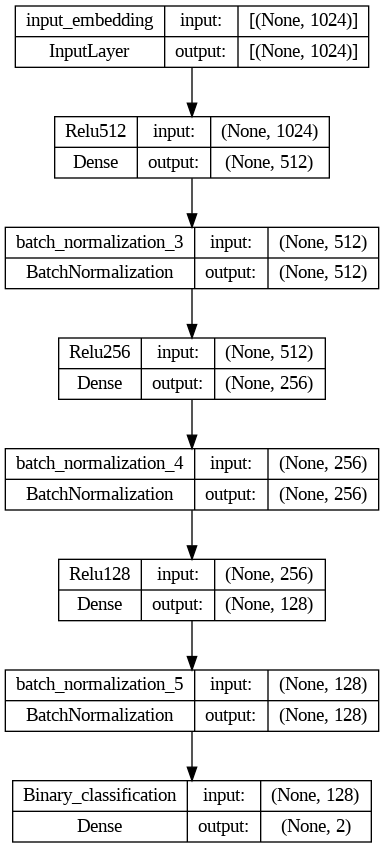

In [ ]:
tf.keras.utils.plot_model(my_model, show_shapes=True)

In [ ]:
lr_list = [0.001, 0.001/2]
history_list_adam = []
history_list_adamax = []
test_accu_pd = pd.DataFrame(columns = lr_list, index=['adam', 'adamax'])
test_loss_pd = pd.DataFrame(columns = lr_list, index=['adam', 'adamax'])
my_metric = 'accuracy'

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=5,
                                              restore_best_weights=True)
print(device)
for lr in lr_list:
  # Set optimizers for current learning rate
  my_adam = tf.keras.optimizers.Adam(
      learning_rate = lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07
      )
  my_adamax = tf.keras.optimizers.Adamax(
      learning_rate= lr,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      weight_decay=None,
      clipnorm=None
  )
  # complile model for adam
  my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=my_adam,
                  metrics=[my_metric])
  print(f'running training loop for adam with lr {lr}')
  # run training loop for adam
  with tf.device('/device:GPU:0'):
    history = my_model.fit(train_ds,
                          epochs=50,
                          validation_data=val_ds,
                          callbacks=callback
                          )
  # Log train/val history
  history_list_adam.append(history)
  # Log test loss/accuracy
  loss, accuracy = my_model.evaluate(test_ds)
  test_accu_pd[lr]['adam'] = accuracy
  test_loss_pd[lr]['adam'] = loss
  # Reset model to initial weights
  my_model.load_weights('rando_normal_init.h5')

  # complile model for adamax
  my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=my_adamax,
                  metrics=[my_metric])
  print(f'running training loop for adamax with lr {lr}')
  # run training loop for adam
  with tf.device('/device:GPU:0'):
    history = my_model.fit(train_ds,
                          epochs=50,
                          validation_data=val_ds,
                          callbacks=callback
                          )
  history_list_adamax.append(history)
  loss, accuracy = my_model.evaluate(test_ds)
  test_accu_pd[lr]['adamax'] = accuracy
  test_loss_pd[lr]['adamax'] = loss
  # Reset model to initial weights
  my_model.load_weights('rando_normal_init.h5')




cuda
running training loop for adam with lr 0.001
Epoch 1/50
519/519 [==============================] - 163s 289ms/step - loss: 0.5826 - accuracy: 0.7253 - val_loss: 0.9244 - val_accuracy: 0.5314
Epoch 2/50
519/519 [==============================] - 5s 10ms/step - loss: 0.5566 - accuracy: 0.7453 - val_loss: 0.8925 - val_accuracy: 0.5313
Epoch 3/50
519/519 [==============================] - 5s 10ms/step - loss: 0.5278 - accuracy: 0.7601 - val_loss: 0.9077 - val_accuracy: 0.5335
Epoch 4/50
519/519 [==============================] - 7s 14ms/step - loss: 0.5123 - accuracy: 0.7733 - val_loss: 1.2946 - val_accuracy: 0.4948
Epoch 5/50
519/519 [==============================] - 5s 9ms/step - loss: 0.5154 - accuracy: 0.7752 - val_loss: 1.0301 - val_accuracy: 0.5099
Epoch 6/50
519/519 [==============================] - 7s 13ms/step - loss: 0.4980 - accuracy: 0.7792 - val_loss: 1.1675 - val_accuracy: 0.5283
Epoch 7/50
519/519 [==============================] - 5s 9ms/step - loss: 0.4968 - accurac

In [ ]:
# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the loss for each history.
for i, history in enumerate(history_list_adam):
  ax1.plot(history.history['val_loss'], label=f'Learning rate {lr_list[i]} (Adam)')
for i, history in enumerate(history_list_adamax):
  ax1.plot(history.history['val_loss'], label=f'Learning rate {lr_list[i]} (Adamax)')

# Set the title and axis labels for the first subplot.
ax1.set_title('val_Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('val_Loss')

# Plot the accuracy for each history.
for i, history in enumerate(history_list_adam):
  ax2.plot(history.history['val_accuracy'], label=f'Learning rate {lr_list[i]} (Adam)')
for i, history in enumerate(history_list_adamax):
  ax2.plot(history.history['val_accuracy'], label=f'Learning rate {lr_list[i]} (Adamax)')

# Set the title and axis labels for the second subplot.
ax2.set_title('Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Val Accuracy')

# Add a legend to each subplot.
ax1.legend(prop={'size': 6})
ax2.legend(prop={'size': 6})


# Show the plot.
plt.show()


In [ ]:
print(device)
my_model.load_weights('rando_normal_init.h5')
my_metric = 'accuracy'

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=5,
                                              restore_best_weights=True)

my_adam = tf.keras.optimizers.Adamax(
    learning_rate = 0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07)

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=my_adam,
                  metrics=[my_metric])
with tf.device('/device:GPU:0'):
  history = my_model.fit(train_ds,
                        epochs=50,
                        validation_data=val_ds,
                        callbacks=callback
                        )

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print(f"Loss:  {loss:.3f}")
print(f"Accuracy:  {accuracy:.3f}")

120/120 [==============================] - 0s 1ms/step - loss: 0.7492 - accuracy: 0.5035
Loss:  0.749
Accuracy:  0.504


In [ ]:
def plot_loss_and_accuracy(history):
  try:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Val'], loc='upper left')
    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_title('Model accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Val'], loc='upper left')
    plt.show()
  except Exception as e:
    print("Something went wrong with plotting loss/accuracy progress: ",e)

plot_loss_and_accuracy(history)

In [ ]:
class YAMNetParams():
    # Copyright 2019 The TensorFlow Authors All Rights Reserved.
    #
    # Licensed under the Apache License, Version 2.0 (the "License");
    # you may not use this file except in compliance with the License.
    # You may obtain a copy of the License at
    #
    #     http://www.apache.org/licenses/LICENSE-2.0
    #
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.
    # ==============================================================================

    """Hyperparameters for YAMNet."""

    # The following hyperparameters (except PATCH_HOP_SECONDS) were used to train YAMNet,
    # so expect some variability in performance if you change these. The patch hop can
    # be changed arbitrarily: a smaller hop should give you more patches from the same
    # clip and possibly better performance at a larger computational cost.
    SAMPLE_RATE = 16000
    STFT_WINDOW_SECONDS = 0.025
    STFT_HOP_SECONDS = 0.010
    MEL_BANDS = 64
    MEL_MIN_HZ = 125
    MEL_MAX_HZ = 7500
    LOG_OFFSET = 0.001
    PATCH_WINDOW_SECONDS = 0.96
    PATCH_HOP_SECONDS = 0.48
    # PATCH_WINDOW_SECONDS = 0.48
    # PATCH_HOP_SECONDS = 0.24
    PATCH_FRAMES = int(round(PATCH_WINDOW_SECONDS / STFT_HOP_SECONDS))
    PATCH_BANDS = MEL_BANDS
    NUM_CLASSES = 521
    CONV_PADDING = 'same'
    BATCHNORM_CENTER = True
    BATCHNORM_SCALE = False
    BATCHNORM_EPSILON = 1e-4
    CLASSIFIER_ACTIVATION = 'sigmoid'

    FEATURES_LAYER_NAME = 'features'
    EXAMPLE_PREDICTIONS_LAYER_NAME = 'predictions'


# NOTE for our inference, don't need overlapping windows
# YAMNetParams.PATCH_HOP_SECONDS = YAMNetParams.PATCH_WINDOW_SECONDS
# YAMNetParams.PATCH_HOP_SECONDS = 1.0

In [ ]:
ckpt_url = "https://github.com/w-hc/torch_audioset/releases/download/v0.1/yamnet.pth"
import torch.nn as nn
import os.path as osp
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import hub

__all__ = ['yamnet', 'yamnet_category_metadata']

class Conv2d_tf(nn.Conv2d):
    """
    Conv2d with the padding behavior from TF Slim
    """
    def __init__(self, *args, **kwargs):
        # remove padding argument to avoid conflict
        padding = kwargs.pop("padding", "SAME")
        # initialize nn.Conv2d
        super().__init__(*args, **kwargs)
        self.padding = padding
        assert self.padding == "SAME"
        self.num_kernel_dims = 2
        self.forward_func = lambda input, padding: F.conv2d(
            input, self.weight, self.bias, self.stride,
            padding=padding, dilation=self.dilation, groups=self.groups,
        )

    def tf_SAME_padding(self, input, dim):
        input_size = input.size(dim + 2)
        filter_size = self.kernel_size[dim]

        dilate = self.dilation
        dilate = dilate if isinstance(dilate, int) else dilate[dim]
        stride = self.stride
        stride = stride if isinstance(stride, int) else stride[dim]

        effective_kernel_size = (filter_size - 1) * dilate + 1
        out_size = (input_size + stride - 1) // stride
        total_padding = max(
            0, (out_size - 1) * stride + effective_kernel_size - input_size
        )
        total_odd = int(total_padding % 2 != 0)
        return total_odd, total_padding

    def forward(self, input):
        if self.padding == "VALID":
            return self.forward_func(input, padding=0)
        odd_1, padding_1 = self.tf_SAME_padding(input, dim=0)
        odd_2, padding_2 = self.tf_SAME_padding(input, dim=1)
        if odd_1 or odd_2:
            # NOTE: F.pad argument goes from last to first dim
            input = F.pad(input, [0, odd_2, 0, odd_1])

        return self.forward_func(
            input, padding=[ padding_1 // 2, padding_2 // 2 ]
        )


class CONV_BN_RELU(nn.Module):
    def __init__(self, conv):
        super().__init__()
        self.conv = conv
        self.bn = nn.BatchNorm2d(
            conv.out_channels, eps=YAMNetParams.BATCHNORM_EPSILON
        )  # NOTE: yamnet uses an eps of 1e-4. This causes a huge difference
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Conv(nn.Module):
    def __init__(self, kernel, stride, input_dim, output_dim):
        super().__init__()
        self.fused = CONV_BN_RELU(
            Conv2d_tf(
                in_channels=input_dim, out_channels=output_dim,
                kernel_size=kernel, stride=stride,
                padding='SAME', bias=False
            )
        )

    def forward(self, x):
        return self.fused(x)


class SeparableConv(nn.Module):
    def __init__(self, kernel, stride, input_dim, output_dim):
        super().__init__()
        self.depthwise_conv = CONV_BN_RELU(
            Conv2d_tf(
                in_channels=input_dim, out_channels=input_dim, groups=input_dim,
                kernel_size=kernel, stride=stride,
                padding='SAME', bias=False,
            ),
        )
        self.pointwise_conv = CONV_BN_RELU(
            Conv2d_tf(
                in_channels=input_dim, out_channels=output_dim,
                kernel_size=1, stride=1,
                padding='SAME', bias=False,
            ),
        )

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x

class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class YAMNet(nn.Module):
    def __init__(self):
        super().__init__()
        net_configs = [
            # (layer_function, kernel, stride, num_filters)
            (Conv,          [3, 3], 2,   32),
            (SeparableConv, [3, 3], 1,   64),
            (SeparableConv, [3, 3], 2,  128),
            (SeparableConv, [3, 3], 1,  128),
            (SeparableConv, [3, 3], 2,  256),
            (SeparableConv, [3, 3], 1,  256),
            (SeparableConv, [3, 3], 2,  512),
            (SeparableConv, [3, 3], 1,  512),
            (SeparableConv, [3, 3], 1,  512),
            (SeparableConv, [3, 3], 1,  512),
            (SeparableConv, [3, 3], 1,  512),
            (SeparableConv, [3, 3], 1,  512),
            (SeparableConv, [3, 3], 2, 1024),
            (SeparableConv, [3, 3], 1, 1024)
        ]

        input_dim = 1
        self.layer_names = []
        for (i, (layer_mod, kernel, stride, output_dim)) in enumerate(net_configs):
            name = 'layer{}'.format(i + 1)
            self.add_module(name, layer_mod(kernel, stride, input_dim, output_dim))
            input_dim = output_dim
            self.layer_names.append(name)

        self.classifier = nn.Linear(input_dim, 521, bias=True)

    def forward(self, x, to_prob=False):
        for name in self.layer_names:
            mod = getattr(self, name)
            x = mod(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        if to_prob:
            x = torch.sigmoid(x)
        return x




def yamnet(pretrained=True,remove_orig_classifier=True,freeze_grad=True):
    model = YAMNet()
    if pretrained:
        state_dict = hub.load_state_dict_from_url(ckpt_url, progress=True)
        model.load_state_dict(state_dict)
        if (freeze_grad):
            for param in model.parameters():
                param.requires_grad = False

    if remove_orig_classifier:
        model.classifier = Identity()

    return model


def yamnet_category_metadata():
    cat_meta_file = osp.join(
        osp.dirname(osp.realpath(__file__)), 'yamnet_category_meta.yml'
    )
    with open(cat_meta_file) as f:
        cat_meta = yaml.safe_load(f)
    return cat_meta



In [ ]:
class YamnetClassifier(nn.Module):
    def __init__(self,dimensions=[],out_dim=1,activation=nn.ReLU(),freeze_backend_grad=True) -> None:
        super().__init__()
        layers = []
        input_dim=1024
        for dimension in dimensions:
            layers += [nn.Linear(input_dim,dimension,bias=False),
                        # nn.BatchNorm1d(num_features=dimension),
                        activation]
            input_dim = dimension
        layers+=[nn.Linear(input_dim,out_dim,bias=False)]

        self.classifier=nn.Sequential(*layers)
        self.backend = yamnet(pretrained=True,remove_orig_classifier=True,freeze_grad=freeze_backend_grad)
        self.full_layout = nn.Sequential(self.backend,self.classifier)

    def forward(self,x):
        return self.full_layout(x).squeeze()

a = YamnetClassifier()

Downloading: "https://github.com/w-hc/torch_audioset/releases/download/v0.1/yamnet.pth" to /root/.cache/torch/hub/checkpoints/yamnet.pth
100%|██████████| 14.4M/14.4M [00:00<00:00, 139MB/s]


In [ ]:
a.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=1, bias=False)
)